<a href="https://colab.research.google.com/github/arnauldnzegha/DEEP2PDEs/blob/main/Long_and_all_PDENet_11_11_6FILTERS_GENERAL_FORM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Long et al. paper with TensorFlow

Arxiv link:https://arxiv.org/pdf/1710.09668.pdf

# 11*11 filters: with prior knowledge of the form




In [ ]:
import tensorflow as tf
from keras import backend as K 
from keras.models import Model
import math as M
import matplotlib.pyplot as plt
from keras.optimizers import SGD,Adadelta
from keras.layers import Dense, Input,Convolution2D,Lambda,add as kadd
import numpy as np
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
import scipy.io
from keras.regularizers import l1
from random import shuffle
import time
from itertools import product
import zipfile, os
import keras

Using TensorFlow backend.


# data generation

- $u_t + \bf{v}. \nabla u +\rho u =d \Delta u  \ \ \ \ \ \ $ Or  $ \ \ \ \ \  u_t =-\bf{v}. \nabla u -\rho u +d \Delta u \ \ $
 with  $\ \bf{v}=(v_1,v_2)^t$

- $u(t,x,y) = c_0 \frac{a^2}{a^2 +td} e^{-\frac{(x-x_0- tv_1)+(y-y_0- tv_2)}{4(a^2+td)}} e^{-\rho t}$

P , V , V , 0 , d , d , 0


In [ ]:
def u_anal(t,x,y,p=1, v1=2, v2 =0.1, d=0.1):
  #v1, v2 = 0.5, 0.1
  c_0=1.5
  #p=-1
  a=1
  #d=0.1
  x0,y0=0,0
  C=c_0 * (a**2/(a**2+t*d))
  K= np.exp(-((x-x0-t*v1)**2 + (y-y0-t*v2)**2)/(4*(a**2 +t*d)))
  u=C*K*np.exp(-p*t)
  return u

def get_data(nb_t=100,nb_xy=100,p=1, v1=2, v2 =0.1, d=0.1):
    min_t, max_t =0 , 0.99
    min_xy, max_xy =-1, 1
    t = np.linspace(min_t, max_t, nb_t )
    x = np.linspace(min_xy,max_xy, nb_xy )
    y = np.linspace(min_xy,max_xy, nb_xy )
    x_,y_=np.meshgrid(x, y)
    x_,y_=x_.flatten(),y_.flatten()
    u=[]
    xy=np.array(list(zip(x_,y_)))
    for i in range(0,len(t)):
      u_i=[u_anal(t[i],x,y,p,v1,v2,d) for (x,y) in list(zip(x_,y_))]
      u.append(np.array(u_i))
    return t,x,y, np.array(u).reshape(nb_t,nb_xy,nb_xy), np.array(xy).reshape(nb_xy,nb_xy,2)


nb_t,nb_xy=100,100
t,x,y,u,xy=get_data(nb_t,nb_xy)


Here we constraint the filters. Exple: 

$$ q_{00}=
\left[\begin{array}{cc} 
1 & * & * & * & *\\ 
* & * & * & * & *\\
* & * & * & * & *\\
* & * & * & * & *\\
* & * & * & * & *\\
\end{array}\right]
 \ \ \ \ \ \ U_x=
 U \circledast
\left[\begin{array}{cc} 
0 & 0 & * & * & *\\ 
1 & * & * & * & *\\
* & * & * & * & *\\
* & * & * & * & *\\
* & * & * & * & *\\
\end{array}\right]
$$

In [ ]:
#Q00
a1=tf.Variable([1],dtype=tf.dtypes.float64, trainable=False, name='q001')
a2=tf.Variable(tf.random_normal([120] , dtype=tf.dtypes.float64), name='q00x')
q00=tf.concat([a1, a2],0)
q00=tf.reshape(q00, [11, 11,1])

#Q10
a1=tf.Variable([0,0],dtype=tf.dtypes.float64, trainable=False, name='q101')
a2=tf.Variable(tf.random_normal([9] , dtype=tf.dtypes.float64), name='q101x')
a3=tf.Variable([1],dtype=tf.dtypes.float64, trainable=False, name='q102')
a4=tf.Variable(tf.random_normal([109] , dtype=tf.dtypes.float64), name='q10x')
q10=tf.concat([tf.concat([a1, a2],0),tf.concat([a3, a4],0)],0)
q10=tf.reshape(q10, [11, 11,1])

#Q01
a1=tf.Variable([0,1],dtype=tf.dtypes.float64, trainable=False, name='q011')
a2=tf.Variable(tf.random_normal([9] , dtype=tf.dtypes.float64), name='q011x')
a3=tf.Variable([0],dtype=tf.dtypes.float64, trainable=False, name='q012')
a4=tf.Variable(tf.random_normal([109] , dtype=tf.dtypes.float64), name='q01x')
q01=tf.concat([tf.concat([a1, a2],0),tf.concat([a3, a4],0)],0)
q01=tf.reshape(q01, [11, 11,1])

#Q11
a1=tf.Variable([0,0,0],dtype=tf.dtypes.float64, trainable=False, name='q111')
a2=tf.Variable(tf.random_normal([8] , dtype=tf.dtypes.float64), name='q111x')
a3=tf.Variable([0,1],dtype=tf.dtypes.float64, trainable=False, name='q112')
a4=tf.Variable(tf.random_normal([9] , dtype=tf.dtypes.float64), name='q112x')
a5=tf.Variable([0],dtype=tf.dtypes.float64, trainable=False, name='q113')
a6=tf.Variable(tf.random_normal([98] , dtype=tf.dtypes.float64), name='q113x')
q11=tf.concat([tf.concat([a1, a2],0),tf.concat([a3, a4],0)],0)
q11=tf.concat([q11,tf.concat([a5, a6],0)],0)
q11=tf.reshape(q11, [11, 11,1])


#Q20
a1=tf.Variable([0,0,0],dtype=tf.dtypes.float64, trainable=False, name='q201')
a2=tf.Variable(tf.random_normal([8] , dtype=tf.dtypes.float64), name='q111x')
a3=tf.Variable([1,0],dtype=tf.dtypes.float64, trainable=False, name='q202')
a4=tf.Variable(tf.random_normal([9] , dtype=tf.dtypes.float64), name='q202x')
a5=tf.Variable([0],dtype=tf.dtypes.float64, trainable=False, name='q203')
a6=tf.Variable(tf.random_normal([98] , dtype=tf.dtypes.float64), name='q203x')
q20=tf.concat([tf.concat([a1, a2],0),tf.concat([a3, a4],0)],0)
q20=tf.concat([q20,tf.concat([a5, a6],0)],0)
q20=tf.reshape(q20, [11, 11,1])


#Q02
a1=tf.Variable([0,1,0],dtype=tf.dtypes.float64,trainable=False, name='q021')
a2=tf.Variable(tf.random_normal([8] , dtype=tf.dtypes.float64), name='q111x')
a3=tf.Variable([0,0],dtype=tf.dtypes.float64,trainable=False, name='q022')
a4=tf.Variable(tf.random_normal([9] , dtype=tf.dtypes.float64), name='q022x')
a5=tf.Variable([0],dtype=tf.dtypes.float64, trainable=False, name='q023')
a6=tf.Variable(tf.random_normal([98] , dtype=tf.dtypes.float64), name='q023x')
q02=tf.concat([tf.concat([a1, a2],0),tf.concat([a3, a4],0)],0)
q02=tf.concat([q02,tf.concat([a5, a6],0)],0)
q02=tf.reshape(q02, [11, 11,1])


#Q22
a1=tf.Variable([0,0,0,0],dtype=tf.dtypes.float64, trainable=False, name='q221')
a2=tf.Variable(tf.random_normal([7] , dtype=tf.dtypes.float64), name='q221x')
a3=tf.Variable([0,1,0],dtype=tf.dtypes.float64, trainable=False, name='q222')
a4=tf.Variable(tf.random_normal([8] , dtype=tf.dtypes.float64), name='q222x')

a5=tf.Variable([0,0],dtype=tf.dtypes.float64, trainable=False, name='q223')
a6=tf.Variable(tf.random_normal([9] , dtype=tf.dtypes.float64), name='q223x')

a7=tf.Variable([0],dtype=tf.dtypes.float64, trainable=False, name='q224')
a8=tf.Variable(tf.random_normal([10] , dtype=tf.dtypes.float64), name='q224x')

a9=tf.Variable(tf.random_normal([77] , dtype=tf.dtypes.float64), name='q225x')

q22=tf.concat([tf.concat([a1, a2],0),tf.concat([a3, a4],0)],0)
q22=tf.concat([q22,tf.concat([a5, a6],0)],0)
q22=tf.concat([q22,tf.concat([a7, a8],0)],0)
q22=tf.concat([q22, a9],0)
q22=tf.reshape(q22, [11, 11,1])

In [ ]:
q_ij= tf.concat([q00,q10,q01,q11,q20,q02],2)
q_ij=tf.reshape(q_ij, [11, 11,1,6])

"""sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
#print(sess.run(q00))
print("*****************************************")
print(sess.run(q_ij[:,:,0,6]))"""

'sess = tf.InteractiveSession()\nsess.run(tf.global_variables_initializer())\n#print(sess.run(q00))\nprint("*****************************************")\nprint(sess.run(q_ij[:,:,0,6]))'

# tensor flow

Architecture of the PDE-Net

![PDE-net Image](https://github.com/ZichaoLong/PDE-Net/raw/master/figures/pdenet.jpg "PDE-net Image")

In [ ]:
#----- tensor shape of variable u_1 u_2 and x
u_1 = tf.placeholder(tf.float64, [1,100,100,1]) # u at t=i              (input)
u_2 = tf.placeholder(tf.float64, [1,100,100])  # u at t=i+1             (output)
x_x_tf = tf.placeholder(tf.float64, [100,100,2]) #input xy corresponding to u at t=i   (input)       



XY=tf.Variable(xy, name='q0', dtype=tf.dtypes.float64) # tensor that content the position x and y  [100 * 100 * 2]

delta_t = tf.constant(0.01, dtype=tf.dtypes.float64)  # the time stape Delta_t

#-------------------Network Filters-------------------------------------------------
q_0= tf.Variable(tf.random_normal([11, 11, 1, 1], dtype=tf.dtypes.float64), name='q_0')
b_0 = tf.Variable(tf.random_normal([1] , dtype=tf.dtypes.float64), name='b_ij')
#q_ij= tf.Variable(tf.random_normal([5, 5, 1, 7] , dtype=tf.dtypes.float64), name='q_ij')
b_ij = tf.Variable(tf.random_normal([6] , dtype=tf.dtypes.float64), name='b_ij')

alpha_f= tf.Variable(tf.random_normal([6], dtype=tf.dtypes.float64), name='alpha_f')
#alpha_xy= tf.Variable(tf.random_normal([2], dtype=tf.dtypes.float64), name='alpha_xy')
alpha_xy=tf.constant([0,0], dtype=tf.dtypes.float64, name='alpha_xy')

#-------------------First convolution, of form D_0.U 
convD_0 = tf.nn.conv2d(u_1, q_0, strides=1, padding='SAME', name="D_0")
convD_0 = tf.nn.bias_add(convD_0, b_0)
convD_0 = tf.nn.tanh(convD_0)
convD_0=tf.reduce_sum(convD_0, 3)
print(convD_0)

#-------------------Second convolution, of form D_ij.U 
convD_ij= tf.nn.conv2d(u_1, q_ij, strides=1, padding='SAME', name="D_ij")
convD_ij= tf.nn.bias_add(convD_ij, b_ij)
convD_ij= tf.nn.tanh(convD_ij)
print(convD_ij)

#--------------------We multiply the output the conv D_ij.U by a set of coeffients-- and sun it-----
convD_ij=tf.math.multiply(convD_ij,alpha_f)
convD_ij=tf.reduce_sum(convD_ij, 3)
print(convD_ij)

#--------------------same operation for the position x,y-----
x_y=tf.math.multiply(XY,alpha_xy)
x_y= tf.reduce_sum(x_y, 2)
print(x_y)


F=tf.math.add(convD_ij,x_y,name="F")
print(F)
u_pred=tf.math.add(convD_0,delta_t*F,name="U")
print(u_pred)
loss_pdenet=10e+8*tf.losses.mean_squared_error(u_2,u_pred)
#loss_pdenet=tf.losses.mean_squared_error(u_2,u_pred)

#adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
pdenet_op_adam = optimizer.minimize(loss_pdenet)


#L-BFGS optimizer
pdenet_op = tf.contrib.opt.ScipyOptimizerInterface(loss_pdenet, method = 'L-BFGS-B',
                                                   options = {'maxiter': 5000,'maxfun': 5000,'maxcor': 50,'maxls': 50,'ftol' : 1e-50})

pdenet_op_slsqp = tf.contrib.opt.ScipyOptimizerInterface(loss_pdenet, method = 'BFGS',
                                                   options = {'maxiter': 5000,'ftol' : 1e-50})


Tensor("Sum_3:0", shape=(1, 100, 100), dtype=float64)
Tensor("Tanh_3:0", shape=(1, 100, 100, 6), dtype=float64)
Tensor("Sum_4:0", shape=(1, 100, 100), dtype=float64)
Tensor("Sum_5:0", shape=(100, 100), dtype=float64)
Tensor("F_1:0", shape=(1, 100, 100), dtype=float64)
Tensor("U_1:0", shape=(1, 100, 100), dtype=float64)


In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

L-BFGS

In [ ]:
for j in range (0,1):
  tf_dict={u_1:u[0].reshape(1,100,100,1), u_2:u[1].reshape(1,100,100)}
  print(j)
  for t in range(0,98,1):
    #tf_dict={u_1:u[t].reshape(1,100,100,1), u_2:u[t+1].reshape(1,100,100)}
    pdenet_op.minimize(sess, tf_dict)
    u_1t=sess.run(u_pred, tf_dict)
    tf_dict={u_1:u_1t.reshape(1,100,100,1), u_2:u[t+2].reshape(1,100,100)}

print("alpha_xy",sess.run(alpha_xy))
print("alpha_u",sess.run(alpha_f))
error=sess.run(loss_pdenet, {u_1:u[80].reshape(1,100,100,1),u_2:u[81].reshape(1,100,100)})
print("Mean error=",error)

adam optimizer

In [ ]:
#sess = tf.InteractiveSession()
#sess.run(tf.initialize_all_variables())
for j in range (0,7):
  tf_dict={u_1:u[0].reshape(1,100,100,1), u_2:u[1].reshape(1,100,100)}
  print("iter:",j+1)
  for t in range(0,98,1):
    for i in range(0,10*(200-27*j)):
      #sess.run(pdenet_op_adam, tf_dict)
    u_1t=sess.run(u_pred, tf_dict)
    tf_dict={u_1:u_1t.reshape(1,100,100,1), u_2:u[t+2].reshape(1,100,100)}

print("alpha_xy",sess.run(alpha_xy))
print("alpha_u",sess.run(alpha_f))
error=sess.run(loss_pdenet, {u_1:u[80].reshape(1,100,100,1),u_2:u[90].reshape(1,100,100)})
print("Mean error=",error)

Get U directly from the Neural net

In [ ]:
tf_dict={u_1:u[0].reshape(1,100,100,1), u_2:u[1].reshape(1,100,100)}
u_net=np.zeros([100,100,100])
errorG=0
u_net[0]=u[0].reshape(100,100)
for t in range(0,98,1):
  u_1t=sess.run(u_pred, tf_dict)
  errorG+=sess.run(loss_pdenet, tf_dict)
  tf_dict={u_1:u_1t.reshape(1,100,100,1), u_2:u[t+2].reshape(1,100,100)}
  u_net[t+1]=u_1t.reshape(100,100)

print("global mean squared error :", errorG)
print("alpha_xy",sess.run(alpha_xy))
print("alpha_u",sess.run(alpha_f))
error=sess.run(loss_pdenet, {u_1:u[80].reshape(1,100,100,1),u_2:u[81].reshape(1,100,100)})
print("Mean squared error=",error*10)

global mean squared error : 42377453080.390625
alpha_xy [0. 0.]
alpha_u [ 11.48310684   2.24532871 -15.55237277 -12.49910223  19.81963966
   3.98578152]
Mean squared error= 2755904000.0


12167125.0



In [ ]:
"""print(u[40].reshape(1,100,100))
print("**********************************************************************************")
print(sess.run(u_pred, {u_1:u[40].reshape(1,100,100,1)})[:,50])
print("**********************************************************************************")
print(u[41].reshape(1,100,100)[:,50])
print("**********************************************************************************")
print("**********************************************************************************")"""
print("alpha_xy",sess.run(alpha_xy))
print("alpha_u",sess.run(alpha_f))
error=sess.run(loss_pdenet, {u_1:u[80].reshape(1,100,100,1),u_2:u[81].reshape(1,100,100)})
print("Mean error=",error)

p=1 , V1=2 , V2=0.1 , 0 , d=0.1 , d=0.1 , 0

#Obervations

In [ ]:
alpha=sess.run(alpha_f)
t,x,y,u,xy=get_data(nb_t,nb_xy)
_,_,_,u2,_=get_data(nb_t,nb_xy,-1*alpha[0],-1*alpha[1],-1*alpha[2],alpha[4])

In [ ]:
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML
import io
import base64
def plot_dymanics(t,x,y,u, title):
  xi,yi=np.meshgrid(x, y)
  fig = plt.figure()
  fig, (axes) = plt.subplots(figsize=(4, 3))
  rbf1 = scipy.interpolate.Rbf(xi, yi, u[0], function='linear')
  zi1 = rbf1(xi, yi)
  img = axes.imshow(zi1, cmap='jet', vmin=u.min(), vmax=u.max(),  origin='lower',
                    extent=[x.min(), x.max(), y.min(), y.max()], animated=True)
  plt.xlabel("x")
  plt.ylabel("y")
  plt.title(title+" : t="+str(t[0]))
  fig.colorbar(img, ax=axes)
  
  def updatefig(i):
    axes.set_title(title+" : t="+str(t[i]))
    img.set_array(u[i])
    return img,
  
  ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True)
  ani.save(title+'.mp4', writer='ffmpeg', fps=10)

<Figure size 432x288 with 0 Axes>

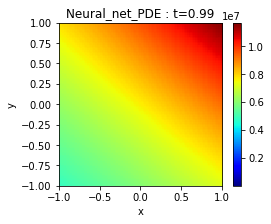

<Figure size 432x288 with 0 Axes>

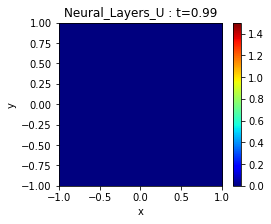

In [ ]:
#plot_dymanics(t,x,y,u, "Initial_PDE")
plot_dymanics(t,x,y,u2, "Neural_net_PDE")
plot_dymanics(t,x,y,u_net, "Neural_Layers_U")

In [ ]:
video1 = io.open('Initial_PDE.mp4', 'r+b').read()
video2 = io.open('Neural_net_PDE.mp4', 'r+b').read()
video3 = io.open('Neural_Layers_U.mp4', 'r+b').read()
encoded1 = base64.b64encode(video1)
encoded2 = base64.b64encode(video2)
encoded3 = base64.b64encode(video3)
HTML(data='''<table><tr><td><video alt="test" controls autoplay="true" loop >
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video></td><td><video alt="test" controls autoplay="true" loop >
                <source src="data:video/mp4;base64,{1}" type="video/mp4" />
             </video></td>
             <td><video alt="test" controls autoplay="true" loop >
                <source src="data:video/mp4;base64,{2}" type="video/mp4" />
             </video></td>
             </tr><table><br/>'''.format(encoded1.decode('ascii'),encoded2.decode('ascii'),encoded3.decode('ascii')))

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
from google.colab import files
saver = tf.train.Saver()
saver.save(sess, 'my_test_model')
u_pred.save_weights('Long_and_all_PDENet_11_11_6F_01.h5')
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
uploaded = drive.CreateFile({'title': 'Long_and_all_PDENet_11_11_6F_01.h5'})
uploaded.SetContentFile('Long_and_all_PDENet_11_11_6F_01.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

# None used codes

In [ ]:
#-------------------training---------------------------------------------------
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #------------je teste juste d'abord en pat de 10. je ferai une boucle pour tester en pas de 0.1 comme c'est beaucoup plus long.
    for j in range (0,30):
      for t in range(20,40):
        tf_dict={u_1:u[t].reshape(1,100,100,1), u_2:u[t+1].reshape(1,100,100)}
        for i in range(0,10*(100-2*t)):
          sess.run(pdenet_op_adam, tf_dict)

In [ ]:
#-------------------training---------------------------------------------------
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #------------je teste juste d'abord en pat de 10. je ferai une boucle pour tester en pas de 0.1 comme c'est beaucoup plus long.
    for j in range (0,5):
      tf_dict={u_1:u[10].reshape(1,100,100,1), u_2:u[19].reshape(1,100,100)}
      for i in range(0,10000):
        sess.run(pdenet_op_adam, tf_dict)

      tf_dict={u_1:u[10].reshape(1,100,100,1), u_2:u[19].reshape(1,100,100)}
      for i in range(0,3000):
        sess.run(pdenet_op_adam, tf_dict)

      tf_dict={u_1:u[20].reshape(1,100,100,1), u_2:u[29].reshape(1,100,100)}
      for i in range(0,2000):
        sess.run(pdenet_op_adam, tf_dict)

      tf_dict={u_1:u[30].reshape(1,100,100,1), u_2:u[39].reshape(1,100,100)}
      for i in range(0,1000):
        sess.run(pdenet_op_adam, tf_dict)

      tf_dict={u_1:u[40].reshape(1,100,100,1), u_2:u[49].reshape(1,100,100)}
      for i in range(0,500):
        sess.run(pdenet_op_adam, tf_dict)

      tf_dict={u_1:u[50].reshape(1,100,100,1), u_2:u[59].reshape(1,100,100)}
      for i in range(0,500):
        sess.run(pdenet_op_adam, tf_dict)

      tf_dict={u_1:u[40].reshape(1,100,100,1), u_2:u[49].reshape(1,100,100)}
      for i in range(0,500):
        sess.run(pdenet_op_adam, tf_dict)
    
    print(u[10].reshape(1,100,100))
    print("**********************************************************************************")
    print(sess.run(u_pred, tf_dict))
    print("**********************************************************************************")
    print(u[19].reshape(1,100,100))
    print("**********************************************************************************")
    print("**********************************************************************************")
    print("alpha_xy",sess.run(alpha_xy))
    print("alpha_u",sess.run(alpha_f))

# keras (not yet working)

In [ ]:
XY=tf.Variable(xy, name='q0')
input_xy= Input(shape=(nb_xy,nb_xy,2))
input_u = Input(shape=(nb_xy,nb_xy,1))

convD_0 =  Convolution2D(1, 3, 5, activation='tanh', border_mode='same', name='q_00')(input_u)
convD_ij =  Convolution2D(5, 3, 5, activation='tanh', border_mode='same', name='q_ij')(input_u)

convD_ij=tf.keras.backend.sum(convD_ij,3)
input_xy=tf.keras.backend.sum(input_xy,3)

F = kadd([convD_ij, input_xy])
u_pred=kadd([convD_0, 0.1*F])
model = Model(inputs=[input_u, input_xy], outputs=u_pred)
sgd = SGD(lr=lr, decay=decay, momentum=momentum, nesterov=True)
model.compile(loss=loss_pde_net, optimizer=sgd,  metrics=['accuracy'])



In [ ]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [ ]:
input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
convD_0 = tf.layers.conv2d(
      inputs=input_layer,
      filters=1,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.tanh)


convD_ij = tf.layers.conv2d(
      inputs=input_layer,
      filters=7,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.tanh)

